In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [3]:
classes = ['helmet','head','person']

In [4]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [5]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    #file_path = open(save_file_name, "a+")
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [6]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  

    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [7]:
!ls /kaggle/working/Dataset/labels

In [8]:
files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
for file in files:
    file_xml = file.split(".")
    get_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

In [9]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/kaggle/input/hard-hat-detection/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


total = 5000
train : 4000
val   : 500
test  : 500


In [10]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/kaggle/working/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/kaggle/working/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        #print(img_sor_file)
        #print(label_sor_file)
        # im = Image.open(rf"{img_sor_file}")
        # im.show()

        # Copy image
        DICT_DIR = '/kaggle/working/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/kaggle/working/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [11]:
copy_data(train_list, '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "train")
copy_data(val_list,   '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "val")
copy_data(test_list,  '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [15]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 20429, done.
remote: Counting objects: 100% (1616/1616), done.
remote: Compressing objects: 100% (876/876), done.
remote: Total 20429 (delta 979), reused 1181 (delta 736), pack-reused 18813
Receiving objects: 100% (20429/20429), 11.40 MiB | 15.48 MiB/s, done.
Resolving deltas: 100% (14163/14163), done.
  Using cached ultralytics-8.0.221-py3-none-any.whl (646 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 20.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


In [16]:
import yaml

# Create configuration
config = {
   "path": "/kaggle/working/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [17]:
!cat data.yaml

names:
- helmet
- head
- person
nc: 3
path: /kaggle/working/Dataset/images
test: test
train: train
val: val


In [18]:
!wandb disabled

W&B disabled.


In [19]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.01

100%|██████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 52.4MB/s]
Ultralytics YOLOv8.0.221 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

In [20]:
!ls /kaggle/working/runs/detect/train

F1_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg
P_curve.png					   train_batch2500.jpg
R_curve.png					   train_batch2501.jpg
args.yaml					   train_batch2502.jpg
confusion_matrix.png				   val_batch0_labels.jpg
confusion_matrix_normalized.png			   val_batch0_pred.jpg
events.out.tfevents.1701559510.a73e118cc554.132.0  val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


In [21]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

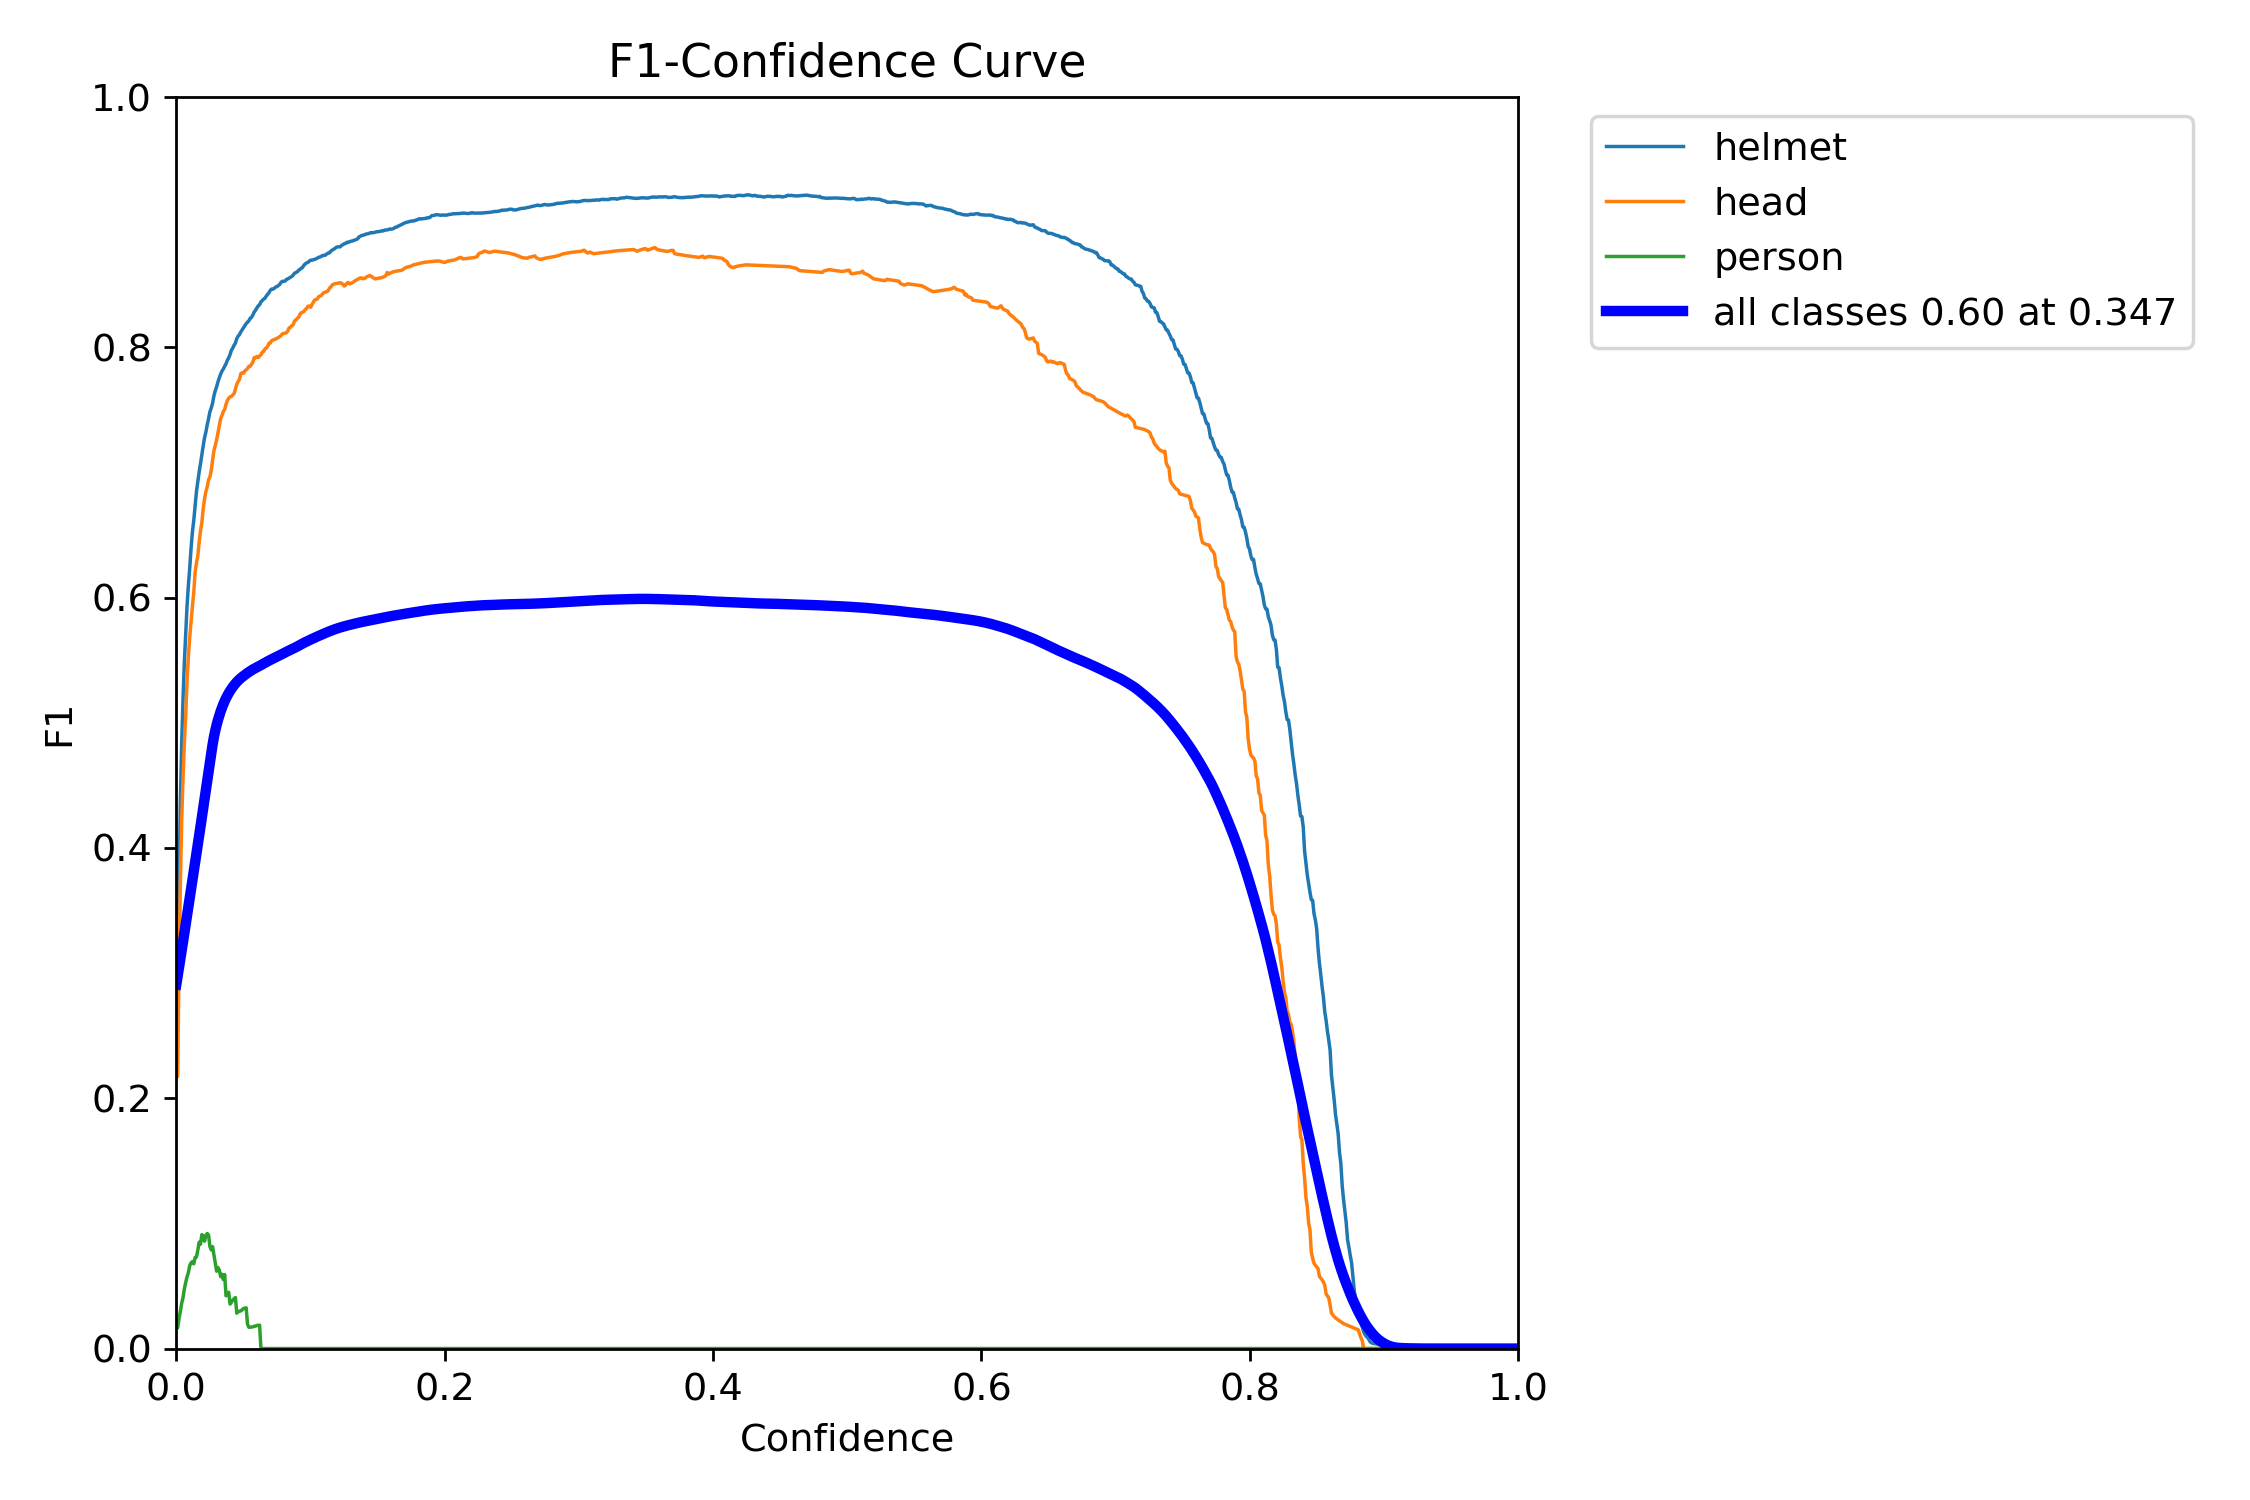

In [22]:
Image(filename='/kaggle/working/runs/detect/train/F1_curve.png', width=600)

In [23]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

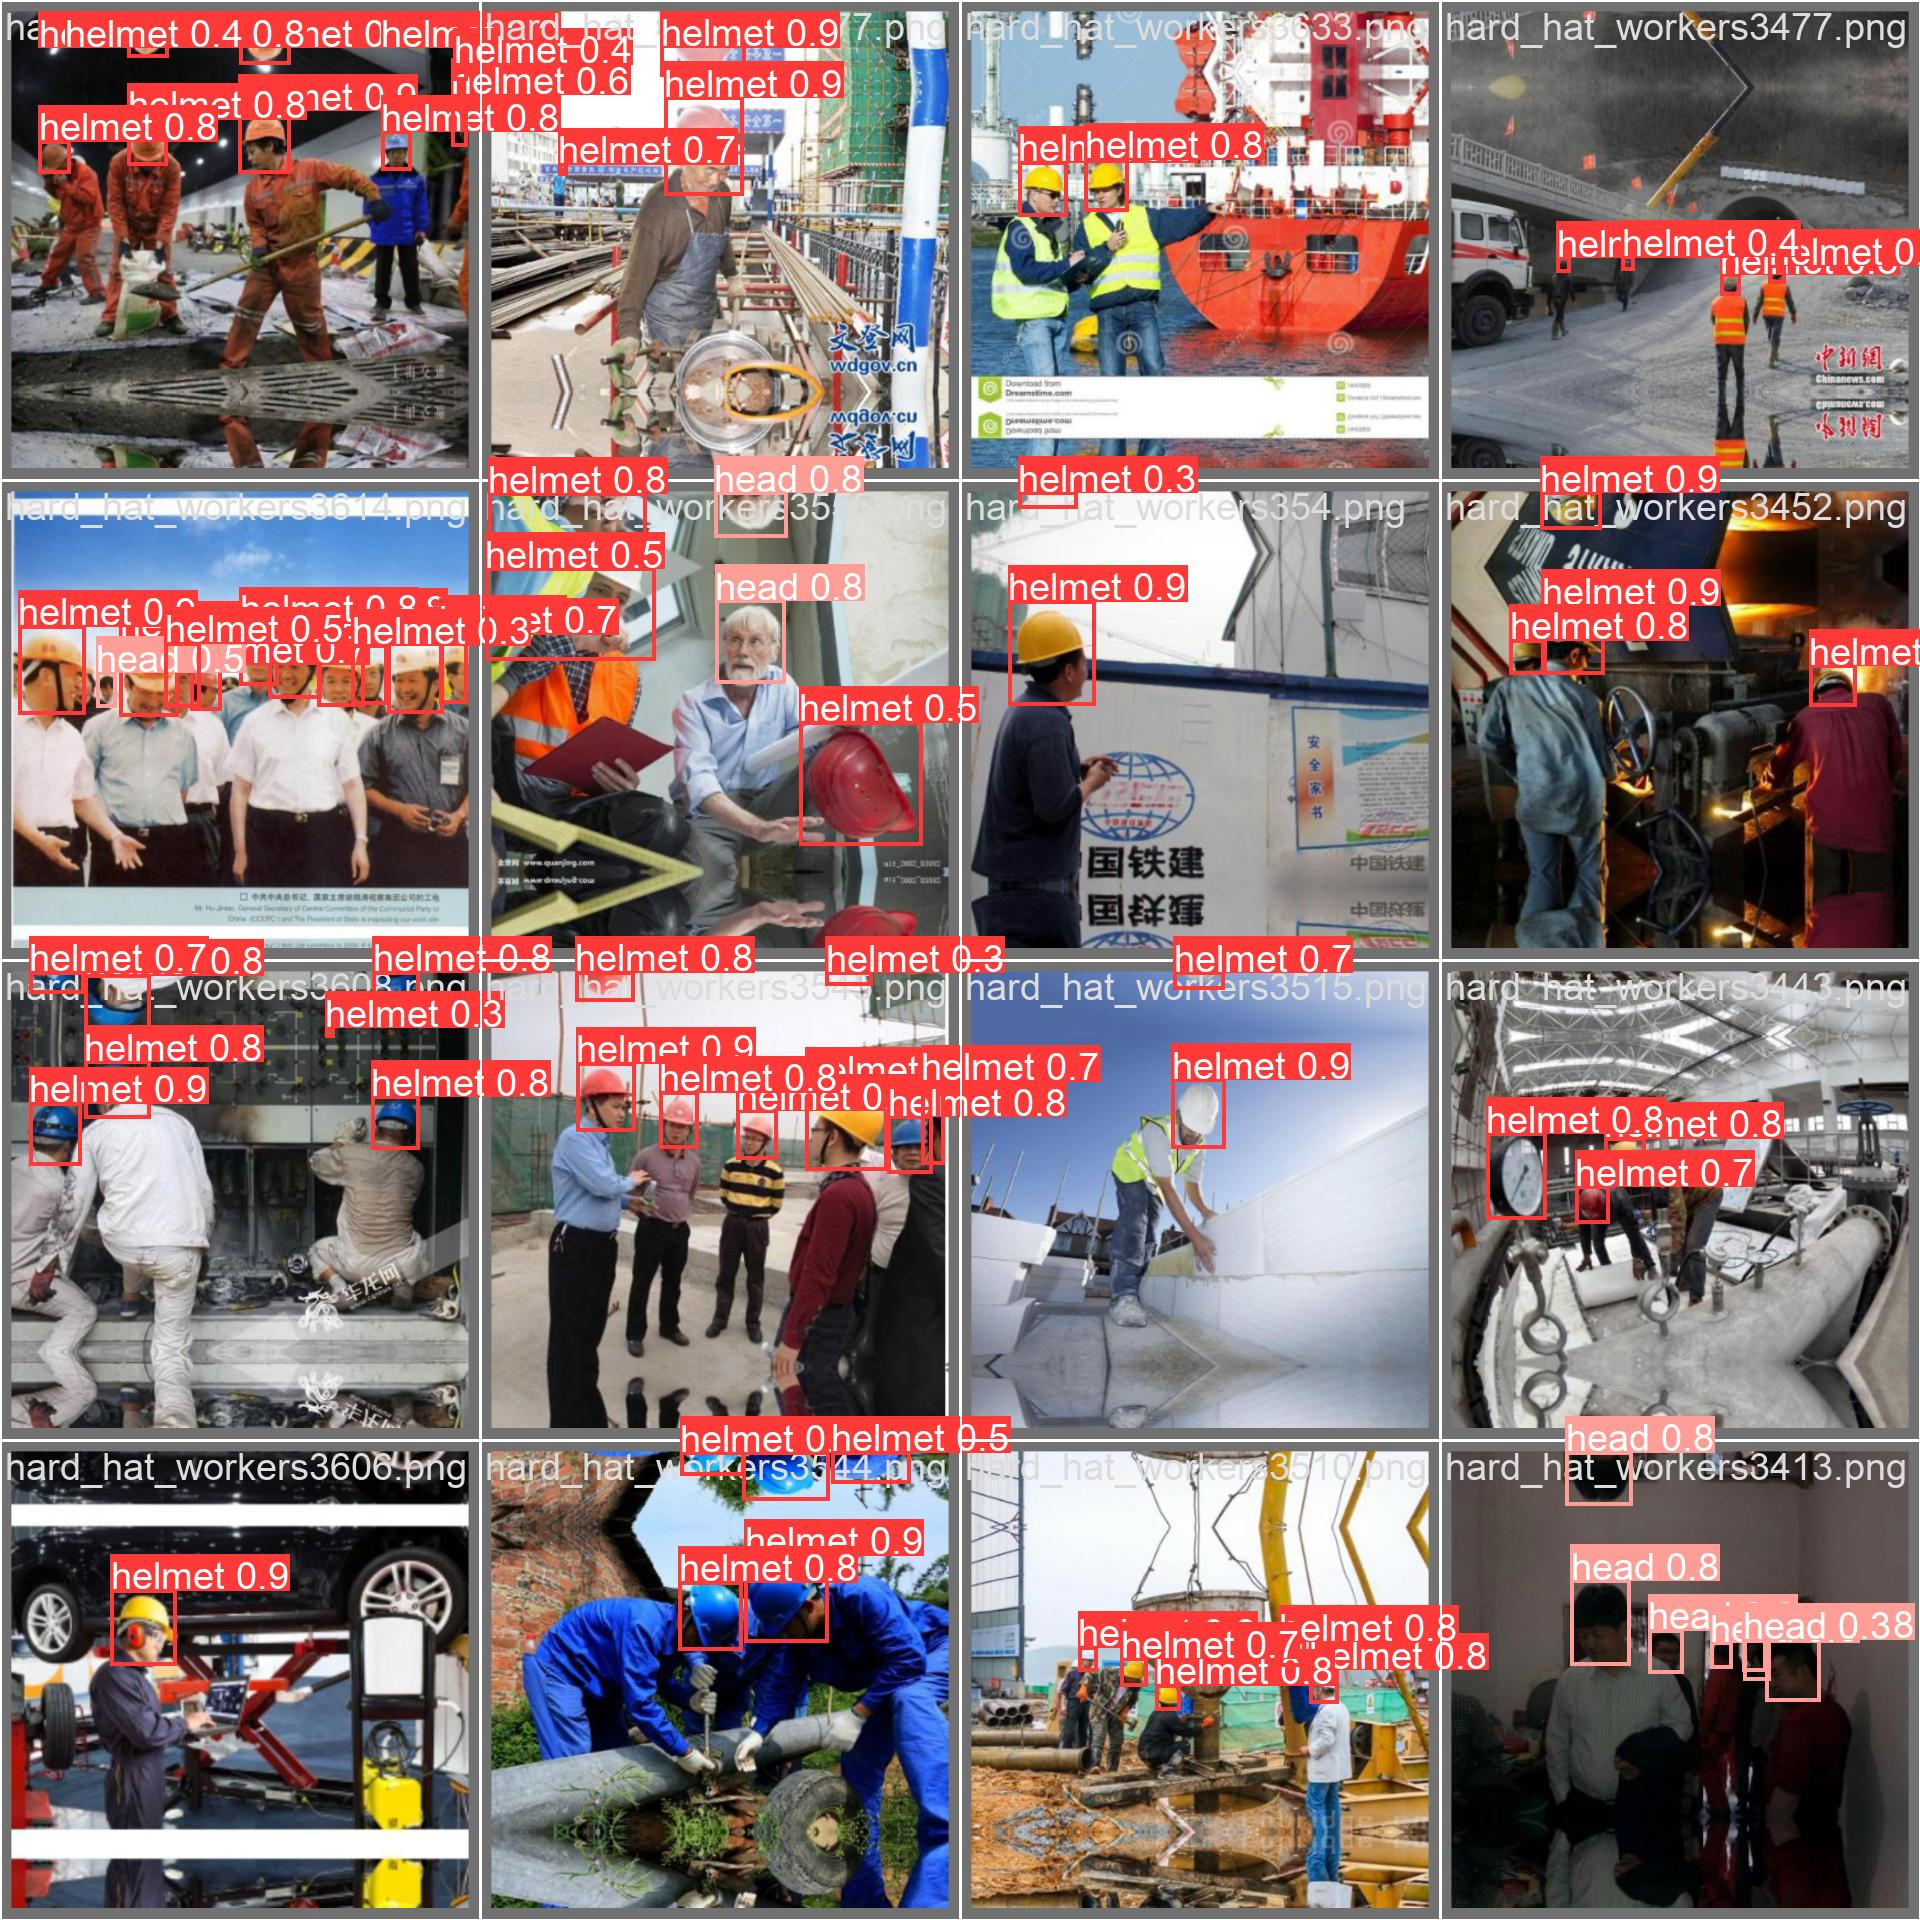

In [24]:
Image(filename='/kaggle/working/runs/detect/train/val_batch0_pred.jpg', width=1000)

In [25]:
!yolo task=detect mode=val model=/kaggle/working/runs/detect/train/weights/best.pt data=data.yaml

Ultralytics YOLOv8.0.221 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/Dataset/labels/val.cache... 500 images, 0 backgrou
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        500       2422      0.944      0.589      0.636      0.418
                helmet        500       1922      0.926      0.912      0.957      0.625
                  head        500        396      0.906      0.854      0.913      0.609
                person        500        104          1          0     0.0389     0.0192
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Speed: 0.7ms preprocess, 5.1ms inference, 0.0ms loss, 1.0

In [1]:
ls